In [3]:
import h5py
import numpy as np
import pandas as pd
import scipy as sp
import networkx as nx
if nx.__version__ == '2.8.8':
    import warnings 
    warnings.simplefilter(action='ignore', category=FutureWarning)
from node_classification import node_categories
names_node_cats = ['bulk', 'root', 'dense sprout', 'sparse sprout', 'inner tree node', 'proper leaf']
import copy

In [4]:
def generate_graph(gid, data_path):
        
    with h5py.File(data_path + f"scikit_data/grid_scikit_{gid}.h5", "r") as hf:
        A = np.array(hf.get("adjacency_matrix"))
        P = np.array(hf.get("P"))
        
    with h5py.File(data_path + f"grids/grid_{gid}.h5", "r") as hf:
        theta = np.array(hf.get("static_result"))
        
    G = nx.convert_matrix.from_numpy_matrix(A)
    
    return G, A, P, theta

def compute_grid_measures(G, A, P, theta):
    
    diffs = [theta[e[0]] - theta[e[1]] for e in G.edges]
    flows = 9 * np.sin(diffs)
    loads = np.abs(flows)
    max_load_idx = np.argmax(loads)
    load_idx = list(list(G.edges)[max_load_idx])
    
    # For backup measures, i.e., post failure of maximally loaded line
    G_post = copy.deepcopy(G)
    G_post.remove_edge(*load_idx)
    post_connected = nx.is_connected(G_post)

    df = pd.DataFrame()
    
    # node features
    
    df["P"] = P
    
    df["AP"] = A.dot(P) / 9.0 
    
    df["AAP"] = A.dot(df["AP"]) / 9.0 
    
    df["AAAP"] = A.dot(df["AAP"]) / 9.0
    
    df["row_sum_AA"] = A.dot(A.dot(np.ones(len(P)))) / (9. * 9.)
    
    df["row_sum_AAA"] = A.dot(df["row_sum_AA"]) / 9.
    
    df["degree"] = [d[1] for d in G.degree]
    
    df["degree_centrality"] = nx.degree_centrality(G).values()
    
    df["neighbor_degree_min"] = [min(df["degree"][G.neighbors(node)]) for node in G.nodes]
    
    df["neighbor_degree_max"] = [max(df["degree"][G.neighbors(node)]) for node in G.nodes]
    
    df["neighbor_degree_mean"] = [np.array(df["degree"][G.neighbors(node)]).mean() for node in G.nodes]
    
    df["clustering"] = nx.clustering(G).values()
    
    df["betweenness_centrality"] = nx.betweenness_centrality(G).values()
    
    df["closeness_centrality"] = nx.closeness_centrality(G).values()
    
    df["load_centrality"] = nx.load_centrality(G).values()
    
    df["eigenvector_centrality"] = nx.eigenvector_centrality(G,max_iter=10000).values()
    
    df["katz_centrality"] = nx.katz_centrality(G).values()
    
    df["second_order_centrality"] = nx.second_order_centrality(G).values()
    
    df["current_flow_closeness_centrality"] = nx.current_flow_closeness_centrality(G).values()
    
    df["current_flow_betweenness_centrality"] = nx.current_flow_betweenness_centrality(G).values()
    
    df["average_neighbor_degree"] = nx.average_neighbor_degree(G).values()
    
    df["harmonic_centrality"] = nx.harmonic_centrality(G).values()
    
    df["square_clustering"] = nx.square_clustering(G).values()
    
    df["eccentricity"] = nx.eccentricity(G).values()
    
    # This redundant feature is only here for backwards compatibility
    df["node_cat"] = node_categories(G, denseThres=5).values()
    for cat in names_node_cats:
#         ddf[cat] = [node == cat for node in df["node_cat"]] -> df[cat] = [int(node == cat) for node in df["node_cat"]
        df[cat] = [int(node == cat) for node in df["node_cat"]]

        
    # new node features
    
    df["fiedler_vector"] = nx.fiedler_vector(G)
    
    connected_to_max_load_line = np.zeros(len(G), dtype=bool)
    connected_to_max_load_line[load_idx] = True
    df["node_connected_to_max_load_line"] = connected_to_max_load_line
    
    # Assign an index to every edge, 
    # find indices of connected edges for very node (e[2]), 
    # use indices to look up corresponding loads
    nx.set_edge_attributes(G, dict(zip(G.edges, range(len(G.edges())))), "edge_idx")
    df["max_load_connected_lines"] = [loads[[e[2] for e in G.edges(nbunch=node, data="edge_idx")]].max() / 9.0 for node in G.nodes]
    df["min_load_connected_lines"] = [loads[[e[2] for e in G.edges(nbunch=node, data="edge_idx")]].min() / 9.0 for node in G.nodes] 
    df["mean_load_connected_lines"] = [loads[[e[2] for e in G.edges(nbunch=node, data="edge_idx")]].mean() / 9.0 for node in G.nodes] 
    
    nx.set_edge_attributes(G, dict(zip(G.edges, 9 * np.cos(diffs))), "laplace_weights")
    df["resistance_distance_centrality"] = nx.current_flow_closeness_centrality(G, weight="laplace_weights").values()
    
    # graph features
    
    N = len(G.nodes)
    M = len(G.edges)
    
    df["degree_assortativity_coefficient"]= nx.degree_assortativity_coefficient(G)
    
    df["transitivity"] = nx.transitivity(G)
    
    df["diameter"] = nx.diameter(G)
    
    nx.set_node_attributes(G, dict(zip(G.nodes, P)), "P")
    
    df["attribute_assortativity_coefficient_P"] = nx.attribute_assortativity_coefficient(G, "P")
    
    df["kirchhoff_index"] = np.reciprocal(df["current_flow_closeness_centrality"]).mean()
    
    df["resistance_distance_kirchhoff_index"] = np.reciprocal(df["resistance_distance_centrality"]).mean()
    
    # new graph features
    
    spec = nx.laplacian_spectrum(G)
    
    df["inverse_algebraic_connectivity"] = 1 / spec[1]
    
    df["eigenratio"] = spec[1] / spec[-1]
     
    df["power_sign_ratio"] = (sum([-P[e[0]] * P[e[1]] for e in G.edges]) + M) / (2 * M)
    
    df["maximal_line_load"] = loads[max_load_idx] / 9.0
    
    df["universal_kuramoto_order_parameter"] = np.cos(diffs).sum() / M
    
    df["connected_post"] = post_connected
    if post_connected:
        # Post failure steady state in DC approximation, i.e, P = L theta
        theta_post = sp.sparse.linalg.lsqr(nx.laplacian_matrix(G_post),P)[0]
        theta_post = theta_post - theta_post[0] # choose first theta as 0
        diffs_post = [theta_post[e[0]] - theta_post[e[1]] for e in G_post.edges]
        loads_post = np.abs(9 * np.sin(diffs_post))      
        # Line outage distribution factor (LODF) in DC approximation
        df["maximal_line_load_post_dc"] = loads_post.max() / 9.0
        df["backup_capacity"] = (loads_post - np.delete(loads, max_load_idx)).max()       
    else:
        df["maximal_line_load_post_dc"] = np.nan
        df["backup_capacity"] = np.nan
  
    return df


def export_measures(data_path, export_path, grids_idx = (1, 10000), _zfill_num = 5, save = False):
    
    grid_ids = [str(i).zfill(_zfill_num) for i in range(grids_idx[0], grids_idx[1] + 1)]
    
    df = pd.DataFrame()
    
    for gid in grid_ids:
        G, A, P, theta = generate_graph(gid, data_path)
        _df = compute_grid_measures(G, A, P, theta)
        df = pd.concat([df,_df], ignore_index=True)
        
    if save:
        df.to_csv(export_path, index=False)
    
    return df
        

In [5]:
root_data_path = '/p/projects/coen/christian/datasets/snbs_homogeneous_dataset/'
root_export_path = '/home/nauck/joined_work/dataset_gnn/datasets_micha_input_features/'

In [ ]:
export_measures(root_data_path + "SN_N020/",
                    root_export_path + "ds20/train/network_measures_final.csv",
                    grids_idx=(1,7000), save=True)
export_measures(root_data_path + "SN_N020/",
                    root_export_path + "ds20/valid/network_measures_final.csv",
                    grids_idx=(7001,8500), save=True)
export_measures(root_data_path + "SN_N020/",
                    root_export_path + "ds20/test/network_measures_final.csv",
                    grids_idx=(8501,10000), save=True)

In [12]:
export_measures(root_data_path + "SN_N100/",
                    root_export_path + "ds100/train/network_measures_final.csv",
                    grids_idx=(1,7000), save=True)
export_measures(root_data_path + "SN_N100/",
                    root_export_path + "ds100/valid/network_measures_final.csv",
                    grids_idx=(7001,8500), save=True)
export_measures(root_data_path + "SN_N100/",
                    root_export_path + "ds100/test/network_measures_final.csv",
                    grids_idx=(8501,10000), save=True)

,P,AP,AAP,AAAP,row_sum_AA,row_sum_AAA,degree,degree_centrality,neighbor_degree_min,neighbor_degree_max,...,kirchhoff_index,resistance_distance_kirchhoff_index,inverse_algebraic_connectivity,eigenratio,power_sign_ratio,maximal_line_load,universal_kuramoto_order_parameter,connected_post,maximal_line_load_post_dc,backup_capacity
0,-1.0,-2.0,-15.0,-34.0,35.0,184.0,8,0.080808,1,8,...,237.749773,26.634241,1.422565,0.007894,0.461538,0.355709,0.993834,True,0.36025,1.718447
1,1.0,-3.0,0.0,-43.0,22.0,99.0,5,0.050505,1,8,...,237.749773,26.634241,1.422565,0.007894,0.461538,0.355709,0.993834,True,0.36025,1.718447
2,-1.0,-2.0,-20.0,-49.0,40.0,201.0,8,0.080808,1,8,...,237.749773,26.634241,1.422565,0.007894,0.461538,0.355709,0.993834,True,0.36025,1.718447
3,-1.0,3.0,-3.0,14.0,13.0,52.0,3,0.030303,2,6,...,237.749773,26.634241,1.422565,0.007894,0.461538,0.355709,0.993834,True,0.36025,1.718447
4,-1.0,-4.0,-7.0,-58.0,33.0,160.0,6,0.060606,3,8,...,237.749773,26.634241,1.422565,0.007894,0.461538,0.355709,0.993834,True,0.36025,1.718447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,1.0,1.0,-1.0,4.0,3.0,10.0,1,0.010101,3,3,...,230.535047,25.820330,1.176014,0.009405,0.520270,0.333333,0.994993,False,NaN,NaN
149996,-1.0,1.0,1.0,0.0,3.0,6.0,1,0.010101,3,3,...,230.535047,25.820330,1.176014,0.009405,0.520270,0.333333,0.994993,False,NaN,NaN
149997,1.0,-1.0,1.0,-11.0,5.0,19.0,1,0.010101,5,5,...,230.535047,25.820330,1.176014,0.009405,0.520270,0.333333,0.994993,False,NaN,NaN
149998,-1.0,1.0,-2.0,3.0,2.0,3.0,1,0.010101,2,2,...,230.535047,25.820330,1.176014,0.009405,0.520270,0.333333,0.994993,False,NaN,NaN


In [16]:
export_measures(root_data_path + "texas/",
                    root_export_path + "dsTexas/network_measures_final.csv",
                    grids_idx=(1,1), _zfill_num=0,save=True)

,P,AP,AAP,AAAP,row_sum_AA,row_sum_AAA,degree,degree_centrality,neighbor_degree_min,neighbor_degree_max,...,kirchhoff_index,resistance_distance_kirchhoff_index,inverse_algebraic_connectivity,eigenratio,power_sign_ratio,maximal_line_load,universal_kuramoto_order_parameter,connected_post,maximal_line_load_post_dc,backup_capacity
0,-1.0,0.000000,-0.061728,-0.012346,0.160494,0.034294,2,0.001048,2,11,...,5665.741039,637.617724,280.678802,0.000208,0.489329,0.619871,0.99273,True,0.999999,8.41369
1,1.0,-0.222222,0.012346,-0.016461,0.086420,0.019204,2,0.001048,3,4,...,5665.741039,637.617724,280.678802,0.000208,0.489329,0.619871,0.99273,True,0.999999,8.41369
2,-1.0,0.333333,-0.012346,0.021948,0.086420,0.024691,3,0.001572,2,3,...,5665.741039,637.617724,280.678802,0.000208,0.489329,0.619871,0.99273,True,0.999999,8.41369
3,1.0,0.000000,0.061728,0.004115,0.086420,0.028807,2,0.001048,3,4,...,5665.741039,637.617724,280.678802,0.000208,0.489329,0.619871,0.99273,True,0.999999,8.41369
4,1.0,0.222222,0.074074,0.017833,0.123457,0.050754,4,0.002095,1,3,...,5665.741039,637.617724,280.678802,0.000208,0.489329,0.619871,0.99273,True,0.999999,8.41369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1905,-1.0,0.111111,0.000000,0.001372,0.123457,0.042524,3,0.001572,3,4,...,5665.741039,637.617724,280.678802,0.000208,0.489329,0.619871,0.99273,True,0.999999,8.41369
1906,-1.0,0.111111,-0.049383,0.002743,0.098765,0.032922,3,0.001572,2,3,...,5665.741039,637.617724,280.678802,0.000208,0.489329,0.619871,0.99273,True,0.999999,8.41369
1907,1.0,0.222222,0.012346,0.009602,0.086420,0.026063,2,0.001048,3,4,...,5665.741039,637.617724,280.678802,0.000208,0.489329,0.619871,0.99273,True,0.999999,8.41369
1908,1.0,0.000000,0.037037,0.006859,0.135802,0.048011,4,0.002095,2,4,...,5665.741039,637.617724,280.678802,0.000208,0.489329,0.619871,0.99273,True,0.999999,8.41369


## more real grids

In [7]:
export_measures(root_data_path + "more_real_grids/elmod/",
                    root_export_path + "elmod/network_measures_final.csv",
                    grids_idx=(1,1), _zfill_num=0,save=True)

,P,AP,AAP,AAAP,row_sum_AA,row_sum_AAA,degree,degree_centrality,neighbor_degree_min,neighbor_degree_max,...,kirchhoff_index,resistance_distance_kirchhoff_index,inverse_algebraic_connectivity,eigenratio,power_sign_ratio,maximal_line_load,universal_kuramoto_order_parameter,connected_post,maximal_line_load_post_dc,backup_capacity
0,1.0,-0.111111,0.000000,-0.006859,0.074074,0.023320,1,0.002288,6,6,...,1186.92027,133.450275,73.377737,0.001031,0.522659,0.435297,0.993601,True,0.999834,8.093257
1,1.0,-0.111111,0.000000,-0.001372,0.024691,0.009602,1,0.002288,2,2,...,1186.92027,133.450275,73.377737,0.001031,0.522659,0.435297,0.993601,True,0.999834,8.093257
2,-1.0,0.000000,-0.012346,-0.006859,0.086420,0.026063,2,0.004577,1,6,...,1186.92027,133.450275,73.377737,0.001031,0.522659,0.435297,0.993601,True,0.999834,8.093257
3,1.0,-0.222222,-0.012346,-0.010974,0.111111,0.035665,2,0.004577,3,6,...,1186.92027,133.450275,73.377737,0.001031,0.522659,0.435297,0.993601,True,0.999834,8.093257
4,-1.0,-0.111111,-0.012346,-0.004115,0.037037,0.012346,1,0.002288,3,3,...,1186.92027,133.450275,73.377737,0.001031,0.522659,0.435297,0.993601,True,0.999834,8.093257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,-1.0,-0.222222,-0.037037,-0.038409,0.185185,0.087791,2,0.004577,7,8,...,1186.92027,133.450275,73.377737,0.001031,0.522659,0.435297,0.993601,True,0.999834,8.093257
434,1.0,0.000000,0.012346,0.001372,0.037037,0.012346,2,0.004577,1,2,...,1186.92027,133.450275,73.377737,0.001031,0.522659,0.435297,0.993601,True,0.999834,8.093257
435,-1.0,0.111111,0.000000,0.001372,0.024691,0.004115,1,0.002288,2,2,...,1186.92027,133.450275,73.377737,0.001031,0.522659,0.435297,0.993601,True,0.999834,8.093257
436,-1.0,-0.111111,0.000000,0.004115,0.049383,0.020576,1,0.002288,4,4,...,1186.92027,133.450275,73.377737,0.001031,0.522659,0.435297,0.993601,True,0.999834,8.093257


In [8]:
export_measures(root_data_path + "more_real_grids/osf_france/",
                    root_export_path + "osf_france/network_measures_final.csv",
                    grids_idx=(1,1), _zfill_num=0,save=True)

,P,AP,AAP,AAAP,row_sum_AA,row_sum_AAA,degree,degree_centrality,neighbor_degree_min,neighbor_degree_max,...,kirchhoff_index,resistance_distance_kirchhoff_index,inverse_algebraic_connectivity,eigenratio,power_sign_ratio,maximal_line_load,universal_kuramoto_order_parameter,connected_post,maximal_line_load_post_dc,backup_capacity
0,-1.0,0.111111,-0.012346,0.001372,0.037037,0.012346,1,0.006897,3,3,...,373.371779,41.980992,23.658091,0.004399,0.484305,0.494117,0.993098,True,0.999553,8.729634
1,1.0,-0.111111,0.012346,0.004115,0.111111,0.039781,3,0.020690,1,6,...,373.371779,41.980992,23.658091,0.004399,0.484305,0.494117,0.993098,True,0.999553,8.729634
2,1.0,-0.111111,0.000000,-0.001372,0.049383,0.009602,1,0.006897,4,4,...,373.371779,41.980992,23.658091,0.004399,0.484305,0.494117,0.993098,True,0.999553,8.729634
3,-1.0,0.000000,-0.012346,0.000000,0.086420,0.038409,4,0.027586,1,2,...,373.371779,41.980992,23.658091,0.004399,0.484305,0.494117,0.993098,True,0.999553,8.729634
4,1.0,0.111111,0.000000,0.006859,0.049383,0.009602,1,0.006897,4,4,...,373.371779,41.980992,23.658091,0.004399,0.484305,0.494117,0.993098,True,0.999553,8.729634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,-1.0,0.000000,-0.037037,-0.016461,0.111111,0.035665,2,0.013793,2,7,...,373.371779,41.980992,23.658091,0.004399,0.484305,0.494117,0.993098,True,0.999553,8.729634
142,1.0,0.000000,-0.012346,-0.013717,0.111111,0.027435,2,0.013793,2,7,...,373.371779,41.980992,23.658091,0.004399,0.484305,0.494117,0.993098,True,0.999553,8.729634
143,-1.0,-0.111111,-0.037037,-0.004115,0.037037,0.012346,1,0.006897,3,3,...,373.371779,41.980992,23.658091,0.004399,0.484305,0.494117,0.993098,True,0.999553,8.729634
144,1.0,0.000000,0.012346,-0.001372,0.037037,0.015089,2,0.013793,1,2,...,373.371779,41.980992,23.658091,0.004399,0.484305,0.494117,0.993098,True,0.999553,8.729634


In [9]:
export_measures(root_data_path + "more_real_grids/osf_gb/",
                    root_export_path + "osf_gb/network_measures_final.csv",
                    grids_idx=(1,1), _zfill_num=0,save=True)

,P,AP,AAP,AAAP,row_sum_AA,row_sum_AAA,degree,degree_centrality,neighbor_degree_min,neighbor_degree_max,...,kirchhoff_index,resistance_distance_kirchhoff_index,inverse_algebraic_connectivity,eigenratio,power_sign_ratio,maximal_line_load,universal_kuramoto_order_parameter,connected_post,maximal_line_load_post_dc,backup_capacity
0,1.0,-0.111111,0.024691,-0.002743,0.024691,0.005487,1,0.008403,2,2,...,441.889742,49.337438,77.956625,0.001733,0.515152,0.222199,0.996313,True,0.999449,8.526522
1,-1.0,0.222222,-0.024691,0.004115,0.049383,0.012346,2,0.016807,1,3,...,441.889742,49.337438,77.956625,0.001733,0.515152,0.222199,0.996313,True,0.999449,8.526522
2,1.0,-0.111111,0.012346,0.001372,0.086420,0.026063,3,0.025210,2,3,...,441.889742,49.337438,77.956625,0.001733,0.515152,0.222199,0.996313,True,0.999449,8.526522
3,-1.0,0.000000,0.000000,-0.001372,0.074074,0.017833,2,0.016807,3,3,...,441.889742,49.337438,77.956625,0.001733,0.515152,0.222199,0.996313,True,0.999449,8.526522
4,-1.0,0.111111,-0.024691,0.005487,0.074074,0.024691,3,0.025210,1,3,...,441.889742,49.337438,77.956625,0.001733,0.515152,0.222199,0.996313,True,0.999449,8.526522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,1.0,0.111111,0.024691,0.005487,0.098765,0.027435,3,0.025210,1,4,...,441.889742,49.337438,77.956625,0.001733,0.515152,0.222199,0.996313,True,0.999449,8.526522
116,-1.0,0.111111,0.012346,0.002743,0.037037,0.010974,1,0.008403,3,3,...,441.889742,49.337438,77.956625,0.001733,0.515152,0.222199,0.996313,True,0.999449,8.526522
117,1.0,0.000000,0.000000,-0.001372,0.123457,0.045267,4,0.033613,1,4,...,441.889742,49.337438,77.956625,0.001733,0.515152,0.222199,0.996313,True,0.999449,8.526522
118,1.0,0.111111,0.000000,0.000000,0.049383,0.013717,1,0.008403,4,4,...,441.889742,49.337438,77.956625,0.001733,0.515152,0.222199,0.996313,True,0.999449,8.526522


In [10]:
export_measures(root_data_path + "more_real_grids/osf_spain/",
                    root_export_path + "osf_spain/network_measures_final.csv",
                    grids_idx=(1,1), _zfill_num=0,save=True)

,P,AP,AAP,AAAP,row_sum_AA,row_sum_AAA,degree,degree_centrality,neighbor_degree_min,neighbor_degree_max,...,kirchhoff_index,resistance_distance_kirchhoff_index,inverse_algebraic_connectivity,eigenratio,power_sign_ratio,maximal_line_load,universal_kuramoto_order_parameter,connected_post,maximal_line_load_post_dc,backup_capacity
0,-1.0,-0.222222,-0.061728,-0.028807,0.086420,0.034294,2,0.020619,2,5,...,186.337411,20.822514,12.994465,0.007218,0.474286,0.320491,0.996202,True,0.999994,7.868257
1,-1.0,-0.222222,-0.061728,-0.028807,0.086420,0.034294,2,0.020619,2,5,...,186.337411,20.822514,12.994465,0.007218,0.474286,0.320491,0.996202,True,0.999994,7.868257
2,-1.0,-0.333333,-0.197531,-0.076818,0.222222,0.126200,5,0.051546,2,7,...,186.337411,20.822514,12.994465,0.007218,0.474286,0.320491,0.996202,True,0.999994,7.868257
3,1.0,-0.222222,-0.037037,-0.027435,0.086420,0.030178,2,0.020619,2,5,...,186.337411,20.822514,12.994465,0.007218,0.474286,0.320491,0.996202,True,0.999994,7.868257
4,-1.0,-0.555556,-0.283951,-0.133059,0.456790,0.275720,7,0.072165,1,9,...,186.337411,20.822514,12.994465,0.007218,0.474286,0.320491,0.996202,True,0.999994,7.868257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,-1.0,0.000000,0.000000,0.000000,0.049383,0.013717,2,0.020619,2,2,...,186.337411,20.822514,12.994465,0.007218,0.474286,0.320491,0.996202,True,0.999994,7.868257
94,1.0,0.000000,0.037037,0.002743,0.061728,0.016461,2,0.020619,2,3,...,186.337411,20.822514,12.994465,0.007218,0.474286,0.320491,0.996202,True,0.999994,7.868257
95,1.0,0.333333,0.024691,0.015089,0.098765,0.037037,3,0.030928,2,3,...,186.337411,20.822514,12.994465,0.007218,0.474286,0.320491,0.996202,True,0.999994,7.868257
96,1.0,-0.111111,0.061728,-0.001372,0.086420,0.028807,3,0.030928,1,3,...,186.337411,20.822514,12.994465,0.007218,0.474286,0.320491,0.996202,True,0.999994,7.868257


root_data_path = '/p/projects/coen/christian/datasets/snbs_homogeneous_dataset/'
root_export_path = '/p/projects/coen/micha/netsci_vs_gnn/'

if True:
    export_measures(root_data_path + "SN_N020/",
                    root_export_path + "grids20/network_measures_final.csv",
                    grids_idx=(1,10000), save=True)

    export_measures(root_data_path + "SN_N100/",
                    root_export_path + "grids100/network_measures_final.csv",
                    grids_idx=(1,10000), save=True)

    export_measures(root_data_path + "texas/",
                    root_export_path + "gridstexas/network_measures_final.csv",
                    grids_idx=(1,1), _zfill_num=0, save=True)

## relevant features



In [ ]:
michas_features = ['P', 'AP', 'AAP', 'AAAP', 'row_sum_AA', 'row_sum_AAA', 'degree',
       'degree_centrality', 'neighbor_degree_min', 'neighbor_degree_max',
       'neighbor_degree_mean', 'clustering', 'betweenness_centrality',
       'closeness_centrality', 'load_centrality', 'eigenvector_centrality',
       'katz_centrality', 'second_order_centrality',
       'current_flow_closeness_centrality',
       'current_flow_betweenness_centrality', 'average_neighbor_degree',
       'harmonic_centrality', 'square_clustering', 'eccentricity', 'bulk',
       'root', 'dense sprout', 'sparse sprout', 'inner tree node',
       'fiedler_vector', 'node_connected_to_max_load_line',
       'max_load_connected_lines', 'min_load_connected_lines',
       'mean_load_connected_lines', 'resistance_distance_centrality',
       'degree_assortativity_coefficient', 'transitivity', 'diameter',
       'attribute_assortativity_coefficient_P', 'kirchhoff_index',
       'resistance_distance_kirchhoff_index', 'inverse_algebraic_connectivity',
       'eigenratio', 'power_sign_ratio', 'maximal_line_load',
       'universal_kuramoto_order_parameter', 'connected_post']

In [ ]:
len(michas_features)

In [ ]:
selected_measures = ["P", "AP", "AAP", "AAAP", "row_sum_AA", "row_sum_AAA", "degree", "degree_centrality", "neighbor_degree_min", "neighbor_degree_max", "neighbor_degree_mean", "clustering", "betweenness_centrality", "closeness_centrality", "load_centrality", "eigenvector_centrality", "katz_centrality", "second_order_centrality", "current_flow_closeness_centrality", "current_flow_betweenness_centrality", "average_neighbor_degree", "harmonic_centrality", "square_clustering", "eccentricity",
                     "fiedler_vector", "node_connected_to_max_load_line", "max_load_connected_lines", "min_load_connected_lines", "mean_load_connected_lines",  "resistance_distance_centrality", "degree_assortativity_coefficient", "transitivity", "diameter", "attribute_assortativity_coefficient_P", "kirchhoff_index", "resistance_distance_kirchhoff_index", "inverse_algebraic_connectivity", "eigenratio", "power_sign_ratio", "maximal_line_load", "universal_kuramoto_order_parameter", "connected_post"]

In [ ]:
unformated = ["P", "AP", "AAP", "AAAP", "row_sum_AA", "row_sum_AAA", "degree", "degree_centrality", "neighbor_degree_min", "neighbor_degree_max",


    "neighbor_degree_mean", "clustering", "betweenness_centrality", "closeness_centrality", "load_centrality",
    
    "eigenvector_centrality", "katz_centrality", "second_order_centrality", "current_flow_closeness_centrality", "current_flow_betweenness_centrality",
    
    
    "average_neighbor_degree", "harmonic_centrality", "square_clustering", "eccentricity", "fiedler_vector", "node_connected_to_max_load_line",
"max_load_connected_lines", "min_load_connected_lines", "mean_load_connected_lines",  "resistance_distance_centrality", "degree_assortativity_coefficient",

    
    "transitivity", "diameter", "attribute_assortativity_coefficient_P", "kirchhoff_index", "resistance_distance_kirchhoff_index", "inverse_algebraic_connectivity"
    "eigenratio",   "power_sign_ratio", "maximal_line_load", "universal_kuramoto_order_parameter", "connected_post"] 
  

In [ ]:
len(unformated)

In [ ]:
len(selected_measures)

# Playground

In [77]:
import time
start=time.time()
export_measures('/p/projects/coen/christian/datasets/snbs_homogeneous_dataset/SN_N100/',
                "", grids_idx=(1,10))#, _zfill_num=0
print(time.time() - start)

3.9734344482421875


In [79]:
data_path = '/p/projects/coen/christian/datasets/snbs_homogeneous_dataset/SN_N020/'


grid_ids = [str(i).zfill(5) for i in range(468,469)]

df = pd.DataFrame()

for gid in grid_ids:
    G, A, P, theta = generate_graph(gid, data_path)
    _df = compute_grid_measures(G, A, P, theta)
    df = pd.concat([df,_df], ignore_index=True)


df[["max_load_connected_lines", "mean_load_connected_lines","min_load_connected_lines", "maximal_line_load"]]

,max_load_connected_lines,mean_load_connected_lines,min_load_connected_lines,maximal_line_load
0,0.258653,0.194444,0.147942,0.258653
1,0.147942,0.062184,0.025673,0.258653
2,0.185392,0.083905,0.001144,0.258653
3,0.111111,0.111111,0.111111,0.258653
4,0.062271,0.024171,0.001144,0.258653
5,0.258653,0.138889,0.074680,0.258653
6,0.111111,0.055556,0.000000,0.258653
7,0.185792,0.130236,0.074680,0.258653
8,0.068373,0.034932,0.013451,0.258653
9,0.111111,0.111111,0.111111,0.258653


In [7]:
measures = ["P", "AP", "AAP", "AAAP", "row_sum_AA", "row_sum_AAA", 
                 "attribute_assortativity_coefficient_P", "degree", "neighbor_degree_max", 
                 "neighbor_degree_min", "clustering", "betweenness_centrality",
                 "closeness_centrality", "load_centrality", "eigenvector_centrality", 
                 "katz_centrality", "second_order_centrality", "current_flow_closeness_centrality", 
                 "current_flow_betweenness_centrality", "average_neighbor_degree", 
                 "harmonic_centrality", "square_clustering", "eccentricity", 
                 "degree_assortativity_coefficient", "transitivity", "diameter", "kirchhoff_index"]


set(measures).issubset(df.columns)

True

In [8]:
nx.degree_assortativity_coefficient(G)

-0.2498564043653073

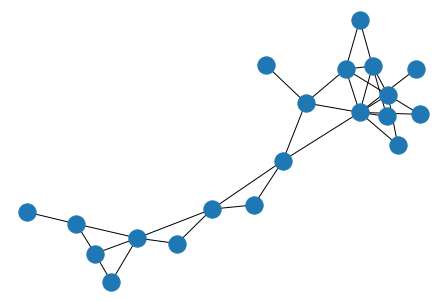

In [9]:
gid="00468"
    
G, A, P, theta = generate_graph(gid, data_path)

diffs = [theta[e[0]] - theta[e[1]] for e in G.edges]
flows = 9 * np.sin(diffs)
loads = np.abs(flows)
max_load_idx = np.argmax(loads)
load_idx = list(list(G.edges)[max_load_idx])

# For backup measures, i.e., post failure of maximally loaded line
G_post = copy.deepcopy(G)
G_post.remove_edge(*load_idx)

nx.is_connected(G_post)
lo = nx.spring_layout(G)
nx.draw(G, pos=lo)

In [13]:
nx.set_edge_attributes(G, dict(zip(G.edges, range(len(G.edges())))), "edge_idx")


In [67]:
import time
start=time.time()
ll = [loads[[e[2] for e in G.edges(nbunch=node, data="edge_idx")]].max() for node in G.nodes]
print(time.time() - start)


ll

0.0008752346038818359


[2.3278761327918795,
 1.3314754268048719,
 1.668524573193219,
 1.0,
 0.5604393146525243,
 2.3278761327918795,
 1.0,
 1.6721238672070775,
 0.6153588243679817,
 1.0,
 0.6976792768377714,
 0.6976792768377714,
 0.5604393146525243,
 0.6153588243679817,
 0.6976792768377714,
 1.0,
 0.624861157664487,
 1.0,
 1.0,
 0.624861157664487]

In [62]:
[e[2] for e in G.edges(nbunch=1, data="edge_idx")]

[0, 4, 5, 6, 7, 8, 9, 10, 11]

In [59]:
?EDV

In [26]:
theta_post = np.linalg.solve(nx.laplacian_matrix(G_post).todense(),P)
theta_post = theta_post - theta_post[0] # choose first theta as 0
diffs_post = [theta_post[e[0]] - theta_post[e[1]] for e in G_post.edges]
loads_post = np.abs(9 * np.sin(diffs_post)) 

In [29]:
nx.laplacian_matrix(G_post) * np.ones(20)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [56]:
th = np.linalg.solve(nx.laplacian_matrix(G).todense(),P)
th = th - th[0]
th

array([ 0.        , -0.14774115, -0.18559219, -0.2967033 , -0.18681319,
        0.25925926,  0.37037037,  0.18518519, -0.17338217, -0.03663004,
       -0.19169719, -0.22527473, -0.12454212, -0.10500611, -0.11416361,
        0.37037037,  0.34259259,  0.35648148,  0.46759259,  0.41203704])

In [57]:
th_po = np.linalg.lstsq(nx.laplacian_matrix(G).todense(),P, rcond=None)[0]
th_po = th_po - th_po[0]
th_po

array([ 0.        , -0.14774115, -0.18559219, -0.2967033 , -0.18681319,
        0.25925926,  0.37037037,  0.18518519, -0.17338217, -0.03663004,
       -0.19169719, -0.22527473, -0.12454212, -0.10500611, -0.11416361,
        0.37037037,  0.34259259,  0.35648148,  0.46759259,  0.41203704])

In [60]:
np.linalg.solve(nx.laplacian_matrix(G).todense(),P) - sp.sparse.linalg.lsqr(nx.laplacian_matrix(G),P)[0]

array([-0.1475336 , -0.14753361, -0.14753361, -0.14753361, -0.14753361,
       -0.14753361, -0.1475336 , -0.14753361, -0.1475336 , -0.14753361,
       -0.14753361, -0.14753361, -0.14753361, -0.14753361, -0.14753361,
       -0.14753361, -0.14753361, -0.14753361, -0.14753361, -0.14753361])

# Old code

In [1]:
import h5py
import numpy as np
import pandas as pd
import scipy as sp

# networkx
import networkx as nx

from node_classification import node_categories


ds20_scikit_path = '/p/projects/coen/christian/datasets/snbs_homogeneous_dataset/SN_N020/scikit_data/'
ds100_scikit_path = '/p/projects/coen/christian/datasets/snbs_homogeneous_dataset/SN_N100/scikit_data/'
texas_scikit_path = '/p/projects/coen/christian/datasets/snbs_homogeneous_dataset/texas/scikit_data/'

num_grids_max_index = 10000
num_grids_texas = 1

ds_format_number_grids_input = '5'
texas_format_number_grids_input= '1'

list_measures = ["P", "AP", "AAP", "AAAP", "row_sum_AA", "row_sum_AAA", "attribute_assortativity_coefficient_P", "degree", "neighbor_degree_max", "neighbor_degree_min", "clustering", "betweenness_centrality","closeness_centrality", "load_centrality", "eigenvector_centrality", "katz_centrality", "second_order_centrality", "current_flow_closeness_centrality", "current_flow_betweenness_centrality", "average_neighbor_degree", "harmonic_centrality", "square_clustering", "eccentricity", "degree_assortativity_coefficient", "transitivity", "diameter", "kirchhoff_index"]

list_name_node_categories = ['bulk', 'root', 'dense sprout', 'sparse sprout', 'inner tree node', 'proper leaf']
add_node_cat = True

class network_measures():
    def __init__(self,list_name_node_categories):
        super(network_measures, self).__init__()
        self.network_measures = {}
        self.list_node_categories = list_name_node_categories
    
    
    def compute_measure(self,G,A,P,measure):
        if measure == 'P':
            self.network_measures["P"] = P
        elif measure == 'AP':
            self.network_measures["AP"] = A.dot(P)/9.0
        elif measure == 'AAP':
            self.network_measures["AAP"] = A.dot(A.dot(P))/(9.*9.)
        elif measure == 'AAAP':
            self.network_measures["AAAP"] = A.dot(A.dot(A.dot(P)))/(9.*9.*9.)
        elif measure == 'row_sum_AA':
            self.network_measures["row_sum_AA"] = A.dot(A.dot(np.ones(len(P))))/(9.*9.)
        elif measure == 'row_sum_AAA':
            self.network_measures["row_sum_AAA"] = A.dot(A.dot(A.dot(np.ones(len(P)))))/(9.*9.*9.)
        elif measure == "degree":
            self.network_measures["degree"] = [d[1] for d in G.degree]
        elif measure == "neighbor_degree_min":
            self.network_measures["neighbor_degree_min"],_ = self.compute_neighbor_degree_min_max(G)
        elif measure == "neighbor_degree_max":
            _, self.network_measures["neighbor_degree_max"] = self.compute_neighbor_degree_min_max(G)
        
        elif measure == "clustering":
            self.network_measures["clustering"] = list(nx.clustering(G).values())
        
        elif measure == "betweenness_centrality":
            self.network_measures["betweenness_centrality"] = list(nx.betweenness_centrality(G).values())
        elif measure == "closeness_centrality":
            self.network_measures["closeness_centrality"] = list(nx.closeness_centrality(G).values())
        elif measure == "load_centrality":
            self.network_measures["load_centrality"] = list(nx.load_centrality(G).values())
        elif measure == "eigenvector_centrality":
            self.network_measures["eigenvector_centrality"] = list(nx.eigenvector_centrality(G,max_iter=10000).values())
        elif measure == "katz_centrality":
            self.network_measures["katz_centrality"] = list(nx.katz_centrality(G).values())
        elif measure == "second_order_centrality":
            self.network_measures["second_order_centrality"] = list(nx.second_order_centrality(G).values())        
        
        elif measure == "current_flow_closeness_centrality":
            self.network_measures["current_flow_closeness_centrality"] = list(nx.current_flow_closeness_centrality(G).values())

        
        elif measure == "current_flow_betweenness_centrality":
            self.network_measures["current_flow_betweenness_centrality"] = list(nx.current_flow_betweenness_centrality(G).values())
        elif measure == "average_neighbor_degree":
            self.network_measures["average_neighbor_degree"] = list(nx.average_neighbor_degree(G).values())
        elif measure == "harmonic_centrality":
            self.network_measures["harmonic_centrality"] = list(nx.harmonic_centrality(G).values())
        elif measure == "square_clustering":
            self.network_measures["square_clustering"] = list(nx.square_clustering(G).values())
        elif measure == "eccentricity":
            self.network_measures["eccentricity"] = list(nx.eccentricity(G).values())
        
        # graph features
        elif measure == "degree_assortativity_coefficient":
            degree_assortativity_coefficient = float(nx.degree_assortativity_coefficient(G))
            self.network_measures["degree_assortativity_coefficient"] = [degree_assortativity_coefficient for i in range(0,len(G.nodes))]
        elif measure == "transitivity":
            transitivity = float(nx.transitivity(G))
            self.network_measures["transitivity"] =  [transitivity for i in range(0,len(G.nodes))] 
        elif measure == "diameter":
            diameter = float(nx.diameter(G))
            self.network_measures["diameter"] = [diameter for i in range(0,len(G.nodes))]
        elif measure == 'attribute_assortativity_coefficient_P':
            attr_assort = nx.attribute_assortativity_coefficient(G, "P")
            self.network_measures["attribute_assortativity_coefficient_P"] = [attr_assort for i in range(0,len(G.nodes))]
        elif measure == "kirchhoff_index":
            self.network_measures["kirchhoff_index"] = list(np.reciprocal(
                self.network_measures["current_flow_closeness_centrality"]).mean().repeat(len(G.nodes)))        

    def convert_node_cat_to_single_variables(self):
        node_cats = self.network_measures["node_cat"]
        N = len(node_cats)
#         name_cat= ['bulk', 'root', 'dense sprout', 'sparse sprout', 'inner tree node', 'proper leaf']
        name_cat = self.list_node_categories
        for cat in name_cat:
            self.network_measures[cat] = [0 for i in range(N)]
        for i in range(N):
            cat = node_cats[i]
            self.network_measures[cat][i] = 1.0
            
    
    def add_node_cats(self,G):
        node_cats = list(node_categories(G, denseThres=5).values())
        self.network_measures["node_cat"] = node_cats
        self.convert_node_cat_to_single_variables()
        
    def compute_list_measures(self,G,A, P, list_measures,node_cat=False):
        for i in range(len(list_measures)):
            self.compute_measure(G,A,P,list_measures[i])
        if node_cat:
            self.add_node_cats(G)
    
    def return_dataframe_measures(self,num_nodes):
        network_measure_names = list(self.network_measures.keys())
        dataframe = pd.DataFrame(columns=network_measure_names, index=np.arange(1,num_nodes+1))
        dataframe.index.name = "node"
        num_measures = len(network_measure_names)
        for i in range(num_nodes):
            for j in range(num_measures):
                measure = network_measure_names[j]
                dataframe.at[i+1,measure] = self.network_measures[measure][i]
        return dataframe
    

    def get_measure_bounds(self):
        network_measure_names = list(self.network_measures.keys())
        dataframe = pd.DataFrame(columns=network_measure_names, index=["min", "max"])
        for measure in self.network_measures:
            dataframe.at["min", measure] = min(self.network_measures[measure])
            dataframe.at["max", measure] = max(self.network_measures[measure])
        return dataframe
    
    def compute_neighbor_degree_min_max(self,G):
        degree_list = [d[1] for d in G.degree]
        min_degree_neighbor = []
        max_degree_neighbor = []
        for i in range(len(G.nodes)):
            degree_neighbors = []
            for n in G.neighbors(i):
                degree_neighbors.append(degree_list[n]) 
            min_degree_neighbor.append(min(degree_neighbors))
            max_degree_neighbor.append(max(degree_neighbors))
        return min_degree_neighbor, max_degree_neighbor
        
def generate_graph(index,path_dir, format_number_grids):
    id = format(index, '0'+format_number_grids)
    file_to_read = path_dir + 'grid_scikit_'+ str(id) + '.h5'
    hf = h5py.File(file_to_read, 'r')
    A = hf.get('adjacency_matrix')
    A = np.array(A)
    P = hf.get('P')
    P = np.array(P)
    hf.close()
    # It's bad style to use a relative path here, both it's not the only case of bad style
    file_to_read = path_dir + '../grids/grid_'+ str(id) + '.h5'
    hf = h5py.File(file_to_read, 'r')
    theta = np.array(hf.get('static_result'))
    hf.close()
    G = nx.convert_matrix.from_numpy_matrix(A, parallel_edges=False, create_using=None)
    # add node properties
    P_dict = dict(enumerate(P.flatten(), 0))
    nx.set_node_attributes(G, P_dict, "P")
    return G, A, P, theta
    
        
def update_bounds(computed_boundaries, previous_boundaries):
    names = list(computed_boundaries.columns)
    for measure in names:
        bds_prev = previous_boundaries[measure]
        bds_computed = computed_boundaries[measure]
        if bds_prev["min"] < bds_computed["min"]:
            bds_computed["min"] = bds_prev["min"]
        if bds_prev["max"] > bds_computed["max"]:
            bds_computed["max"] = bds_prev["max"]
    return computed_boundaries 
    
def get_boundaries_of_measures(index_start, index_end, list_measures, list_name_node_categories, input_path_dir, format_number_grids):
    G1, A1, P1 = generate_graph(index_start, input_path_dir, format_number_grids)
    grid_measures = network_measures(list_name_node_categories)
    grid_measures.compute_list_measures(G1,A1, P1, list_measures)
    computed_bounds = grid_measures.get_measure_bounds()
    for i in range(index_start+1,index_end+1):
        G, A, P = generate_graph(i, input_path_dir, format_number_grids)
        grid_measures = network_measures(list_name_node_categories)
        grid_measures.compute_list_measures(G,A,P,list_measures)
        boundaries = grid_measures.get_measure_bounds()
        computed_boundaries = update_bounds(computed_bounds,boundaries)
    return computed_bounds

def normalize_measures(measures,boundaries,list_name_node_categories):
    for measure in list(measures.columns):
        array= measures[measure]
        not_normalizable = list_name_node_categories.copy()
        not_normalizable.append("node_cat")
        if measure not in not_normalizable: 
            bounds = computed_bounds[measure]
            for i in array.index:
                array[i] = (array[i] - bounds["min"])/(bounds["max"]-bounds["min"])
    return measures
        

def export_measures(index_start, index_end,node_cat,list_node_categories, input_path_dir, format_number_grids, boundaries=False):    
    path_output_dir = input_path_dir
    for i in range(index_start,index_end+1):
        G, A, P, theta = generate_graph(i, input_path_dir, format_number_grids)
        grid_measures = network_measures(list_node_categories)
        grid_measures.compute_list_measures(G,A,P,list_measures,node_cat)
        num_nodes = G.number_of_nodes()
        dataframe_measures = grid_measures.return_dataframe_measures(num_nodes)
        id = format(i, '0'+format_number_grids)
        if type(boundaries) == bool:
            dataframe_measures.to_csv(path_output_dir + 'network_measures_not_normalized'+str(id) + '.csv')
        else:
            normalized_measures = normalize_measures(dataframe_measures,boundaries,list_name_node_categories)
            normalized_measures.to_csv(path_output_dir + 'network_measures_'+str(id) + '.csv')
            

print("init finished")

#computed_bounds_20 = get_boundaries_of_measures(1, num_grids_max_index, list_measures,list_name_node_categories, ds20_scikit_path, ds_format_number_grids_input)
#computed_bounds_100 = get_boundaries_of_measures(1, num_grids_max_index, list_measures,list_name_node_categories, ds100_scikit_path, ds_format_number_grids_input)
#computed_bounds_texas = get_boundaries_of_measures(1, num_grids_texas, list_measures,list_name_node_categories, texas_scikit_path, texas_format_number_grids_input)
#
#computed_bounds = update_bounds(computed_bounds_20, computed_bounds_100)
#computed_bounds_final = update_bounds(computed_bounds_texas, computed_bounds)
#export_measures(1,num_grids_max_index,add_node_cat,list_name_node_categories, ds20_scikit_path, ds_format_number_grids_input, boundaries=computed_bounds_final)
#export_measures(1,num_grids_max_index,add_node_cat,list_name_node_categories, ds100_scikit_path, ds_format_number_grids_input, boundaries=computed_bounds_final)
#export_measures(1,1,add_node_cat,list_name_node_categories, texas_scikit_path, texas_format_number_grids_input, boundaries=computed_bounds_final)

#export_measures(1,num_grids_max_index,add_node_cat,list_name_node_categories, ds20_scikit_path, ds_format_number_grids_input)
#export_measures(1,num_grids_max_index,add_node_cat,list_name_node_categories, ds100_scikit_path, ds_format_number_grids_input)
#export_measures(1,num_grids_texas,add_node_cat,list_name_node_categories, texas_scikit_path, texas_format_number_grids_input)


init finished
